In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pathlib import Path
from sqlalchemy import create_engine
from ds100_utils import fetch_and_cache

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)

## SQL Joins

In [66]:
import sqlite3
conn = sqlite3.connect('test.db')

In [112]:
conn.executescript("""
DROP TABLE IF EXISTS users;
DROP TABLE IF EXISTS orders;

CREATE TABLE users(
    id INTEGER PRIMARY KEY, 
    name TEXT
);

INSERT INTO users VALUES 
    (1, 'sam'),
    (2, 'manana'),
    (3, 'leo'),
    (4, 'steph');

CREATE TABLE orders(
    item TEXT PRIMARY KEY,
    price NUMERIC,
    name TEXT
);

INSERT INTO orders VALUES 
    ('water', 2, 'caleb'),
    ('tea', 10.5, 'sam'),
    ('latte', 4, 'manana'),
    ('boba', 4.5, 'leo');
""");

In [113]:
def print_sql(s):
    first, *rest = s.strip().split('\n')
    print(f'sql> {first}')
    for line in rest:
        print(f'...> {line}')
    for result in conn.execute(s):
        print(result)

print_sql('SELECT * FROM users;')
print_sql('SELECT * FROM orders;')

sql> SELECT * FROM users;
(1, 'sam')
(2, 'manana')
(3, 'leo')
(4, 'steph')
sql> SELECT * FROM orders;
('water', 2, 'caleb')
('tea', 10.5, 'sam')
('latte', 4, 'manana')
('boba', 4.5, 'leo')


In [114]:
query = '''
SELECT *
FROM users
WHERE id >= 3;
'''

print_sql(query)

sql> SELECT *
...> FROM users
...> WHERE id >= 3;
(3, 'leo')
(4, 'steph')


In [115]:
query = '''
SELECT *
FROM users, orders
'''
print_sql(query)

sql> SELECT *
...> FROM users, orders
(1, 'sam', 'water', 2, 'caleb')
(1, 'sam', 'tea', 10.5, 'sam')
(1, 'sam', 'latte', 4, 'manana')
(1, 'sam', 'boba', 4.5, 'leo')
(2, 'manana', 'water', 2, 'caleb')
(2, 'manana', 'tea', 10.5, 'sam')
(2, 'manana', 'latte', 4, 'manana')
(2, 'manana', 'boba', 4.5, 'leo')
(3, 'leo', 'water', 2, 'caleb')
(3, 'leo', 'tea', 10.5, 'sam')
(3, 'leo', 'latte', 4, 'manana')
(3, 'leo', 'boba', 4.5, 'leo')
(4, 'steph', 'water', 2, 'caleb')
(4, 'steph', 'tea', 10.5, 'sam')
(4, 'steph', 'latte', 4, 'manana')
(4, 'steph', 'boba', 4.5, 'leo')


In [116]:
query = '''
SELECT *
FROM users JOIN orders
  ON users.name = orders.name
'''
print_sql(query)

sql> SELECT *
...> FROM users JOIN orders
...>   ON users.name = orders.name
(1, 'sam', 'tea', 10.5, 'sam')
(2, 'manana', 'latte', 4, 'manana')
(3, 'leo', 'boba', 4.5, 'leo')


In [117]:
query = '''
SELECT *
FROM users, orders
  WHERE users.name = orders.name
'''
print_sql(query)

sql> SELECT *
...> FROM users, orders
...>   WHERE users.name = orders.name
(1, 'sam', 'tea', 10.5, 'sam')
(2, 'manana', 'latte', 4, 'manana')
(3, 'leo', 'boba', 4.5, 'leo')


In [118]:
query = '''
SELECT *
FROM users LEFT JOIN orders
  ON users.name = orders.name
'''
print_sql(query)

sql> SELECT *
...> FROM users LEFT JOIN orders
...>   ON users.name = orders.name
(1, 'sam', 'tea', 10.5, 'sam')
(2, 'manana', 'latte', 4, 'manana')
(3, 'leo', 'boba', 4.5, 'leo')
(4, 'steph', None, None, None)


Doing an outer join is possible but not very concise:

In [120]:
query = '''
SELECT users.id, users.name, orders.item, orders.price
FROM users LEFT JOIN orders
  ON users.name = orders.name
'''
print_sql(query)

sql> SELECT users.id, users.name, orders.item, orders.price
...> FROM users LEFT JOIN orders
...>   ON users.name = orders.name
(1, 'sam', 'tea', 10.5)
(2, 'manana', 'latte', 4)
(3, 'leo', 'boba', 4.5)
(4, 'steph', None, None)


In [121]:
query = '''
SELECT users.id, users.name, orders.item, orders.price
FROM users LEFT JOIN orders
  ON users.name = orders.name
UNION
SELECT users.id, users.name, orders.item, orders.price
FROM orders LEFT JOIN users
  ON users.name = orders.name
'''
print_sql(query)

sql> SELECT users.id, users.name, orders.item, orders.price
...> FROM users LEFT JOIN orders
...>   ON users.name = orders.name
...> UNION
...> SELECT users.id, users.name, orders.item, orders.price
...> FROM orders LEFT JOIN users
...>   ON users.name = orders.name
(None, None, 'water', 2)
(1, 'sam', 'tea', 10.5)
(2, 'manana', 'latte', 4)
(3, 'leo', 'boba', 4.5)
(4, 'steph', None, None)


## IMDB Data

In [9]:
# From https://www.imdb.com/interfaces/
fetch_and_cache('https://datasets.imdbws.com/title.basics.tsv.gz', 'titles.tsv.gz')
fetch_and_cache('https://datasets.imdbws.com/name.basics.tsv.gz', 'names.tsv.gz')
!gunzip -kf data/titles.tsv.gz
!gunzip -kf data/names.tsv.gz
!ls -lh data

Using cached version that was downloaded (UTC): Fri Jul  5 12:10:57 2019
Using cached version that was downloaded (UTC): Fri Jul  5 12:11:07 2019
total 2712400
-rw-r--r--  1 sam  staff   539M Jul  5 12:11 names.tsv
-rw-r--r--  1 sam  staff   176M Jul  5 12:11 names.tsv.gz
-rw-r--r--  1 sam  staff   484M Jul  5 12:10 titles.tsv
-rw-r--r--  1 sam  staff   102M Jul  5 12:10 titles.tsv.gz


In [10]:
!head -n5 data/titles.tsv

tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000001	short	Carmencita	Carmencita	0	1894	\N	1	Documentary,Short
tt0000002	short	Le clown et ses chiens	Le clown et ses chiens	0	1892	\N	5	Animation,Short
tt0000003	short	Pauvre Pierrot	Pauvre Pierrot	0	1892	\N	4	Animation,Comedy,Romance
tt0000004	short	Un bon bock	Un bon bock	0	1892	\N	\N	Animation,Short


In [15]:
!head -n 10 data/titles.tsv

tconst	titleType	primaryTitle	originalTitle	isAdult	startYear	endYear	runtimeMinutes	genres
tt0000001	short	Carmencita	Carmencita	0	1894	\N	1	Documentary,Short
tt0000002	short	Le clown et ses chiens	Le clown et ses chiens	0	1892	\N	5	Animation,Short
tt0000003	short	Pauvre Pierrot	Pauvre Pierrot	0	1892	\N	4	Animation,Comedy,Romance
tt0000004	short	Un bon bock	Un bon bock	0	1892	\N	\N	Animation,Short
tt0000005	short	Blacksmith Scene	Blacksmith Scene	0	1893	\N	1	Comedy,Short
tt0000006	short	Chinese Opium Den	Chinese Opium Den	0	1894	\N	1	Short
tt0000007	short	Corbett and Courtney Before the Kinetograph	Corbett and Courtney Before the Kinetograph	0	1894	\N	1	Short,Sport
tt0000008	short	Edison Kinetoscopic Record of a Sneeze	Edison Kinetoscopic Record of a Sneeze	0	1894	\N	1	Documentary,Short
tt0000009	movie	Miss Jerry	Miss Jerry	0	1894	\N	45	Romance


In [11]:
!head -n5 data/names.tsv

nconst	primaryName	birthYear	deathYear	primaryProfession	knownForTitles
nm0000001	Fred Astaire	1899	1987	soundtrack,actor,miscellaneous	tt0043044,tt0050419,tt0053137,tt0072308
nm0000002	Lauren Bacall	1924	2014	actress,soundtrack	tt0038355,tt0117057,tt0037382,tt0071877
nm0000003	Brigitte Bardot	1934	\N	actress,soundtrack,producer	tt0049189,tt0054452,tt0057345,tt0059956
nm0000004	John Belushi	1949	1982	actor,writer,soundtrack	tt0080455,tt0078723,tt0077975,tt0072562


In [12]:
!wc data/*.tsv

 9429109 65046269 565579045 data/names.tsv
 5982407 81293691 507519002 data/titles.tsv
 15411516 146339960 1073098047 total


In [13]:
# How to crash your kernel:
# pd.read_csv('data/names.tsv', sep='\t')

In [14]:
# Instead, use sqlite3 (must be run from the terminal)
"""
$ sqlite3 imdb.db
sqlite> .mode tabs
sqlite> .import data/titles.tsv titles
sqlite> .import data/names.tsv names
""";

In [123]:
conn = sqlite3.connect('imdb.db')
print_sql('SELECT * FROM titles LIMIT 10;')

sql> SELECT * FROM titles LIMIT 10;
('tt0000001', 'short', 'Carmencita', 'Carmencita', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000002', 'short', 'Le clown et ses chiens', 'Le clown et ses chiens', '0', '1892', '\\N', '5', 'Animation,Short')
('tt0000003', 'short', 'Pauvre Pierrot', 'Pauvre Pierrot', '0', '1892', '\\N', '4', 'Animation,Comedy,Romance')
('tt0000004', 'short', 'Un bon bock', 'Un bon bock', '0', '1892', '\\N', '\\N', 'Animation,Short')
('tt0000005', 'short', 'Blacksmith Scene', 'Blacksmith Scene', '0', '1893', '\\N', '1', 'Comedy,Short')
('tt0000006', 'short', 'Chinese Opium Den', 'Chinese Opium Den', '0', '1894', '\\N', '1', 'Short')
('tt0000007', 'short', 'Corbett and Courtney Before the Kinetograph', 'Corbett and Courtney Before the Kinetograph', '0', '1894', '\\N', '1', 'Short,Sport')
('tt0000008', 'short', 'Edison Kinetoscopic Record of a Sneeze', 'Edison Kinetoscopic Record of a Sneeze', '0', '1894', '\\N', '1', 'Documentary,Short')
('tt0000009', 'movie', '

In [124]:
for exp in conn.execute('SELECT sql FROM sqlite_master;'):
    print(exp[0])

CREATE TABLE titles(
  "tconst" TEXT,
  "titleType" TEXT,
  "primaryTitle" TEXT,
  "originalTitle" TEXT,
  "isAdult" TEXT,
  "startYear" TEXT,
  "endYear" TEXT,
  "runtimeMinutes" TEXT,
  "genres" TEXT
)
CREATE TABLE names(
  "nconst" TEXT,
  "primaryName" TEXT,
  "birthYear" TEXT,
  "deathYear" TEXT,
  "primaryProfession" TEXT,
  "knownForTitles" TEXT
)
CREATE TABLE "action"(
  id TEXT,
  title TEXT,
  time INT,
  year INT
)
CREATE TABLE action_ppl(
  name TEXT,
  profession,
  born INT,
  title TEXT,
  year INT
)


In [125]:
# Python string substitution (new in Python 3.6)
who, where = 'John', 'here'
f"{who} is {where}"

'John is here'

In [126]:
key = 'tconst'
title = 'primaryTitle'
time = 'runtimeMinutes'
year = 'startYear'
adult = 'isAdult'
kind = 'titleType'

select_action = f'''
SELECT {key} AS id,
  {title} AS title, 
  CAST({time} AS int) AS time, 
  CAST({year} AS int) AS year
FROM titles
WHERE genres LIKE '%Action%' AND
  year > 1900 AND 
  {adult} = '0' AND
  {kind} = 'movie' AND
  time > 60 AND time < 180
'''

create_action_table = f'''
DROP TABLE IF EXISTS action;
CREATE TABLE action AS {select_action};
'''

conn.executescript(create_action_table)
print_sql('SELECT * FROM action LIMIT 10')

sql> SELECT * FROM action LIMIT 10
('tt0004223', 'The Life of General Villa', 105, 1914)
('tt0004635', 'The Squaw Man', 74, 1914)
('tt0005073', 'The Chalice of Courage', 65, 1915)
('tt0006333', '20,000 Leagues Under the Sea', 105, 1916)
('tt0006997', 'The Warrior', 95, 1916)
('tt0008915', 'Bound in Morocco', 64, 1918)
('tt0009560', 'The Romance of Tarzan', 70, 1918)
('tt0009682', 'Tarzan of the Apes', 73, 1918)
('tt0009894', 'The Grey Automobile', 111, 1919)
('tt0010879', 'When the Clouds Roll by', 85, 1919)


We can check to see whether this table is small enough to read into pandas:

In [127]:
print_sql('SELECT COUNT(*) from action')

sql> SELECT COUNT(*) from action
(21597,)


In [128]:
df = pd.read_sql('SELECT * FROM action', conn)
df

,id,title,time,year
0,tt0004223,The Life of General Villa,105,1914
1,tt0004635,The Squaw Man,74,1914
2,tt0005073,The Chalice of Courage,65,1915
...,...,...,...,...
21594,tt9890030,Prematho Mee Karthik,115,2017
21595,tt9897764,River Pirates,90,2018
21596,tt9904066,Fox Hunting,66,2019


In [129]:
df.shape

(21597, 4)

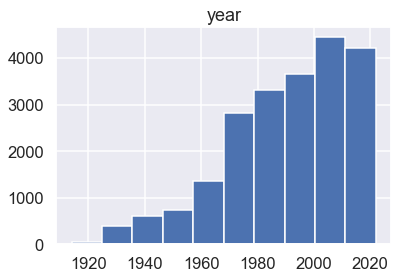

In [130]:
df.hist('year');

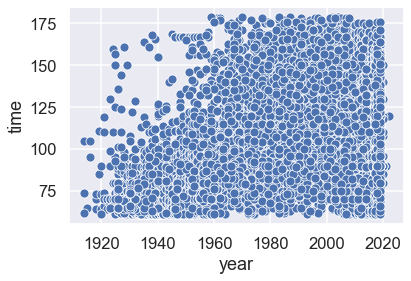

In [37]:
sns.scatterplot(df['year'], df['time']);

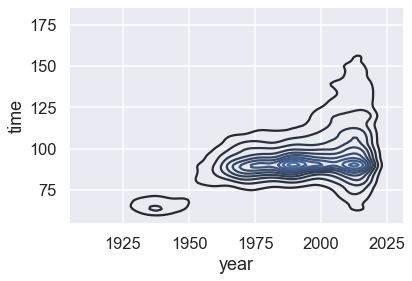

In [38]:
sns.kdeplot(df['year'], df['time']);

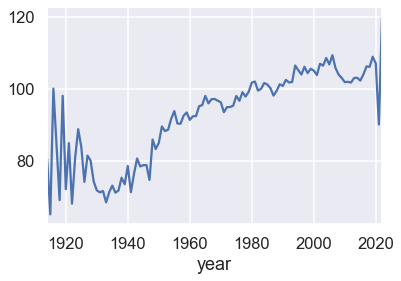

In [39]:
df['time'].groupby(df['year']).mean().plot();

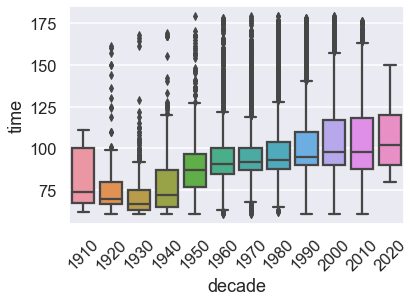

In [40]:
df['decade'] = (df['year'] // 10) * 10
sns.boxplot('decade', 'time', data=df)
plt.xticks(rotation=45);

## Sampling in SQL

In [49]:
pd.read_sql('SELECT * FROM action ORDER BY RANDOM() LIMIT 3', conn)

,id,title,time,year
0,tt7431594,Race 3,160,2018
1,tt0064148,The Chairman,93,1969
2,tt1647465,The Nice Guy,70,2010


In [131]:
three_years = '''
SELECT year FROM action 
  GROUP BY year 
  ORDER BY RANDOM()
  LIMIT 3
'''

cluster_sample = f'''
SELECT * FROM action 
WHERE year IN ({three_years})
'''

pd.read_sql(f'''
SELECT year, COUNT(*) 
FROM ({cluster_sample}) 
GROUP BY year
''', conn)

,year,COUNT(*)
0,1978,258
1,2004,358
2,2011,589


## Ages of Fame

In [51]:
pd.read_sql('SELECT * FROM names LIMIT 10;', conn)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"soundtrack,actor,miscellaneous","tt0043044,tt0050419,tt0053137,tt0072308"
1,nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack","tt0038355,tt0117057,tt0037382,tt0071877"
2,nm0000003,Brigitte Bardot,1934,\N,"actress,soundtrack,producer","tt0049189,tt0054452,tt0057345,tt0059956"
...,...,...,...,...,...,...
7,nm0000008,Marlon Brando,1924,2004,"actor,soundtrack,director","tt0078788,tt0070849,tt0047296,tt0068646"
8,nm0000009,Richard Burton,1925,1984,"actor,producer,soundtrack","tt0087803,tt0057877,tt0061184,tt0059749"
9,nm0000010,James Cagney,1899,1986,"actor,soundtrack,director","tt0031867,tt0035575,tt0055256,tt0029870"


In [132]:
name = 'primaryName'
known = 'knownForTitles'
profession = 'primaryProfession'
born = 'birthYear'

select_actors = f'''
SELECT {name} AS name, 
  CAST({born} AS int) AS born,
  SUBSTR({known}, 0, INSTR({known}, ',')) AS movie_id,
  CASE WHEN {profession} LIKE '%actor%' THEN 'actor' 
    WHEN {profession} LIKE '%actress%' THEN 'actress'   
    END AS profession
FROM names
WHERE {profession} LIKE '%act%' AND
  born > 1800
'''

pd.read_sql(f'{select_actors} LIMIT 10', conn)

,name,born,movie_id,profession
0,Fred Astaire,1899,tt0043044,actor
1,Lauren Bacall,1924,tt0038355,actress
2,Brigitte Bardot,1934,tt0049189,actress
...,...,...,...,...
7,Marlon Brando,1924,tt0078788,actor
8,Richard Burton,1925,tt0087803,actor
9,James Cagney,1899,tt0031867,actor


In [133]:
select = f'''
SELECT name, profession, born, title, year
FROM ({select_actors}) JOIN action
  ON movie_id = id;
'''

conn.executescript(f'''
DROP TABLE IF EXISTS action_ppl;
CREATE TABLE action_ppl AS {select};
''')

pd.read_sql('SELECT * FROM action_ppl LIMIT 10', conn)

,name,profession,born,title,year
0,James Cagney,actor,1899,The Roaring Twenties,1939
1,Gary Cooper,actor,1901,High Noon,1952
2,Kirk Douglas,actor,1916,The Vikings,1958
...,...,...,...,...,...
7,Armin Mueller-Stahl,actor,1930,The International,2009
8,Gérard Pirès,actor,1942,Sky Fighters,2005
9,Jennifer Aniston,actress,1969,The Bounty Hunter,2010


In [134]:
avengers = '''
SELECT *
FROM action_ppl
WHERE title LIKE "%Avengers%"
'''

pd.read_sql(avengers, conn)

,name,profession,born,title,year
0,Robert Downey Jr.,actor,1965,The Avengers,2012
1,Grace Jones,actress,1948,The Avengers,1998
2,Julian Bleach,actor,1963,Avengers: Age of Ultron,2015
...,...,...,...,...,...
16,Mike Capuano,actor,1952,Avengers: Infinity War,2018
17,Brent Reichert,actor,1971,The Avengers,2012
18,Tom Culler,actor,1986,Avengers: Infinity War,2018


In [135]:
pd.read_sql('''
SELECT name, born, year,
  CASE WHEN born < 1980 THEN 'old' 
    WHEN born < 2000 THEN 'not too old' 
    ELSE 'young' END
    AS age
FROM action_ppl
''', conn).sample(10)

,name,born,year,age
9799,David Oliver,1898,1938,old
9513,Francesca Neri,1964,2002,old
4807,Nader Galal,1941,1988,old
...,...,...,...,...
3665,Frank Delfino,1911,1980,old
13522,Paddy Webster,1936,1969,old
1513,Derek Basco,1970,2018,old


In [136]:
df = pd.read_sql('SELECT * FROM action_ppl', conn)
df.shape

(15521, 5)

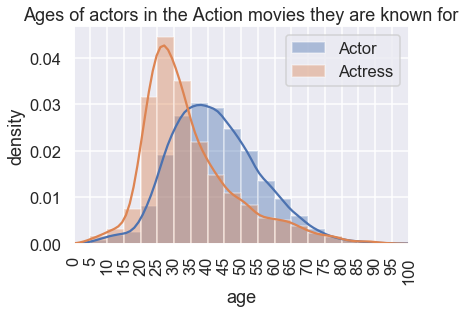

In [137]:
df['age'] = df['year'] - df['born']
bins = np.linspace(0, 100, 21)
sns.distplot(df[df['profession']=='actor']['age'], bins=bins)
sns.distplot(df[df['profession']=='actress']['age'], bins=bins)
plt.legend(labels=['Actor', 'Actress'])
plt.xticks(bins, rotation=90)
plt.xlim(0, 100)
plt.ylabel('density');
plt.title('Ages of actors in the Action movies they are known for');